# Disclaimers

- I have no formal education in data science
- All data used is pubicly accessible via the Reddit API
- About 80% of this code (maybe more) was generated by ChatGPT

https://linkedin.com/in/caseyjohnsonwv

In [14]:
from dotenv import load_dotenv
load_dotenv()

import os

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
OPENAI_MODEL = os.environ['OPENAI_MODEL']

REDDIT_CLIENT_ID = os.environ['REDDIT_CLIENT_ID']
REDDIT_CLIENT_SECRET = os.environ['REDDIT_CLIENT_SECRET']
REDDIT_USERNAME = os.environ['REDDIT_USERNAME']
REDDIT_USER_AGENT = 'r/rollercoasters trip report analysis'

# Gather Raw Data

Using the Python package `praw` to scrape r/rollercoasters for "trip report" posts

In [349]:
import calendar
import csv
from datetime import datetime
import re
import pandas as pd
from praw import Reddit

# Setup Reddit API with PRAW
reddit = Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT,
    username=REDDIT_USERNAME,
)

# Fetch posts from r/rollercoasters
subreddit = reddit.subreddit('rollercoasters')
posts = []

# Search for posts with "trip report" in title or body
for submission in subreddit.search("trip report", limit=1000):  # Adjust limit as needed
    title = submission.title
    
    # Convert created_utc to datetime object
    post_date = datetime.utcfromtimestamp(submission.created_utc)
    post_month_name = post_date.strftime('%B')
    post_year = post_date.year

    # Look for OP's top-level comment
    full_text = submission.selftext
    submission.comments.replace_more(limit=0)  # Load all comments
    for comment in submission.comments:
        if comment.is_submitter and comment.parent_id == submission.id:
            full_text = f"{full_text}\n\n{comment.body}"

    # Build post URL for reference
    post_url = f"https://reddit.com{submission.permalink}"
    
    # Append the post details to the list
    posts.append([title, post_month_name, post_year, full_text, post_url])

# Convert to a Pandas DataFrame
df = pd.DataFrame(posts, columns=['Title', 'Post Month', 'Post Year', 'Content', 'URL'])

# Drop rows where 'Content' is NaN or an empty string
df = df[df['Content'].str.strip().astype(bool)]
df = df[df['Content'].str.len() > 2000]

# Sort by month and year
df['Post Month'] = pd.Categorical(df['Post Month'], categories=list(calendar.month_name[1:]), ordered=True)
df = df.sort_values(by=['Post Year', 'Post Month'], ascending=[False, False])

# Print DataFrame preview
df = df.reset_index().drop(columns=['index'])
print(df.shape)
display(df.sample(n=5))

# Save DataFrame
df.to_csv('_raw.csv', index=False, quoting=csv.QUOTE_ALL)

(145, 5)


,Title,Post Month,Post Year,Content,URL
142,First time trip to [Hershey Park] and [SFGA]! ...,July,2023,"I’ll keep this as short as possible, this was ...",https://reddit.com/r/rollercoasters/comments/1...
50,First visit Trip Report to [Hersheypark],July,2024,Visited the park for my first time last week a...,https://reddit.com/r/rollercoasters/comments/1...
35,[Movie Park Germany] Trip Report - June 2024 R...,August,2024,Probably my least anticipated park of the trip...,https://reddit.com/r/rollercoasters/comments/1...
28,"[Cedar Point] Trip Report 8/7, 8/8",August,2024,After years of drooling at the coasters of Ced...,https://reddit.com/r/rollercoasters/comments/1...
83,[Phantasialand] Trip Report #2/5,June,2024,"This is park 2 of 5 on my European trip, hope ...",https://reddit.com/r/rollercoasters/comments/1...


# Enhance Raw Data

Use `gpt-4o-mini` to extract features from the post's title and text. Examples:
- Name of the country where the park is located
- Is this their first visit? (boolean)
- Did they purchase a wait time reduction product? (boolean)
- Sentiment about food offerings (Positive, Negative, Mixed, or Neutral)

In [350]:
from openai import OpenAI
import json
import pandas as pd

# Reload DataFrame from CSV
raw_df = pd.read_csv('_raw.csv', quoting=csv.QUOTE_ALL)

# Add new column to the existing DataFrame
raw_df['Analysis'] = None

# Define the prompt
prompt = """
You are tasked with analyzing a Reddit post about a theme park trip.
Based on the title and the post content provided, return a valid JSON object with the following keys.
Assume sentiments are positive unless otherwise stated.
{
    "Park Name": Name of the amusement park visited. By subreddit rules, this should be contained in [Square Brackets] in the title. It may be an abbreviation. If so, infer the true name
    "Park Continent": Continent where the park is located, based on your own knowledge
    "Solo Visit": Binary 0/1 value indicating if the poster visited the park alone
    "First Visit": Binary 0/1 value indicating if this is the poster's first visit to the park in question
    "Home Park": Binary 0/1 value indicating if this is the poster's closest amusement park to home
    "Purchased Line Skip": Binary 0/1 value indicating if the poster purchased the park's wait time reduction product
    "Storm Impact": Binary 0/1 value indicating if the poster's day was impacted by precipitation or wind
    "Temperature Impact": Binary 0/1 value indicating if the poster's day was impacted by unusually hot or cold temperatures
    "Closures Impact": Binary 0/1 value indicating if the poster's day was impacted by unexpected ride closures
    "Overhyped": Binary 0/1 value indicating if the poster believes the park receives more hype than it's worth
    "Overhated": Binary 0/1 value indicating if the poster believes the park receives more hate than it deserves
    "Expectations Met": Binary 0/1 value indicating if the park met the poster's expectations, regardless of how high or low they were
    "Ride Sentiment": Sentiment about the park's roller coasters and flat rides (choose an integer: 0 for "Negative", 1 for "Positive")
    "Operations Sentiment": Sentiment about the pace of ride operators and the park's staffing (choose an integer: 0 for "Negative", 1 for "Positive")
    "Lineup Depth Sentiment": Sentiment about the park's quality "falls off" after a top few rides (choose an integer: 0 for "Negative", 1 for "Positive")
    "Food Sentiment": Sentiment about the park's food (choose an integer: 0 for "Negative", 1 for "Positive")
    "Crowd Sentiment": Sentiment about the park's crowd levels (choose an integer: 0 for "Negative", 1 for "Positive")
    "Merchandise Sentiment": Sentiment about the park's merchandise offerings (choose an integer: 0 for "Negative", 1 for "Positive")
    "Loose Articles Sentiment": Sentiment about the park's requirement or non-requirement of free or paid loose article lockers (choose an integer: 0 for "Negative", 1 for "Positive")
    "Value Sentiment": Sentiment about whether the money spent was worth it (choose an integer: 0 for "Negative", 1 for "Positive")
    "Expectations Sentiment": Sentiment about whether the poster's expected to have a good or bad day at this park (choose an integer: 0 for "Negative", 1 for "Positive")
    "Experience Sentiment": Sentiment about the overall experience of visiting the park (choose an integer: 0 for "Negative", 1 for "Positive")
}
Do not provide any other exposition. Do not use a formatted code block. Just return the exact text of the JSON.
"""

# Iterateively hit the LLM for analysis
client = OpenAI(api_key=OPENAI_API_KEY)
MAX_LLM_CALLS = 500
for idx, row in raw_df.head(n=MAX_LLM_CALLS).iterrows():
    title, content = row['Title'], row['Content']
    response = client.chat.completions.create(
        model=OPENAI_MODEL,
        messages=[
            {'role': 'system', 'content': prompt},
            {'role': 'user', 'content': f"Title: {title}\nContent: {content}"}
        ],
        temperature=0.0,
    )
    try:
        content = response.choices[0].message.content
        analysis = json.loads(content)
        raw_df.at[idx, 'Analysis'] = analysis
    except json.JSONDecodeError:
        print(f"Failed to decode analysis as JSON: {content}")
        raw_df.at[idx, 'Analysis'] = {}

# Normalize the JSON responses into separate columns
analysis_df = pd.json_normalize(raw_df['Analysis'])

# Concatenate the original DataFrame with the new columns from the JSON responses and drop what we don't need
analyzed_df = pd.concat([raw_df.drop(columns=['Analysis']), analysis_df], axis=1)

# Clean up the DataFrame a little
print(analyzed_df.shape)
analyzed_df['Park Name'] = analyzed_df['Park Name'].str.title()
display(analyzed_df.head(n=5))

# Save DataFrame
analyzed_df.to_csv('_analyzed.csv', index=False, quoting=csv.QUOTE_ALL)

(145, 27)


,Title,Post Month,Post Year,Content,URL,Park Name,Park Continent,Solo Visit,First Visit,Home Park,...,Ride Sentiment,Operations Sentiment,Lineup Depth Sentiment,Food Sentiment,Crowd Sentiment,Merchandise Sentiment,Loose Articles Sentiment,Value Sentiment,Expectations Sentiment,Experience Sentiment
0,[Carowinds] Trip Report 8/31 - An Honest Review,September,2024,"We were at Carowinds on Saturday, 8/31. First ...",https://reddit.com/r/rollercoasters/comments/1...,Carowinds,North America,0,1,0,...,1,1,0,1,0,1,1,0,1,1
1,Trip Report [Six Flags America],September,2024,"(This was from Aug 23rd, but I'm just getting ...",https://reddit.com/r/rollercoasters/comments/1...,Six Flags America,North America,0,0,1,...,1,1,0,1,1,1,1,1,1,1
2,First Visit to Hershey Park [Trip Report],September,2024,August 15th\n\nWhile I have been to Kneobels m...,https://reddit.com/r/rollercoasters/comments/1...,Hershey Park,North America,0,1,0,...,1,0,1,1,0,1,1,1,1,1
3,[Holiday World] Trip Report 9/1/24,September,2024,"My thighs hurt. I'm 14 yrs old, 6'1 and 200 po...",https://reddit.com/r/rollercoasters/comments/1...,Holiday World,North America,0,0,0,...,1,1,1,1,1,1,0,1,1,1
4,[Dorney Park] Trip Report 24/8/2024,September,2024,Took a road trip from Toronto with my brother ...,https://reddit.com/r/rollercoasters/comments/1...,Dorney Park,North America,0,1,0,...,1,0,0,1,0,0,1,0,0,0


# Prepare for Modeling

- Profile each column to determine if they're worth exploring
- Drop bad data & remove columns that would be bad features
- Analyze correlation between features and resolve multicollinearity

In [351]:
# Reload DataFrame from CSV
modeling_df = pd.read_csv('_analyzed.csv', quoting=csv.QUOTE_ALL)

In [352]:
# Generate profile for each column
for col in modeling_df.drop(columns=['Title']).columns:
    print(f"Column: {col}")
    print(modeling_df[col].value_counts().reset_index().rename(columns={'index': 'Value', col: 'Value'}))
    print("\n" + "-"*40 + "\n")

Column: Post Month
       Value  count
0     August     42
1       July     34
2        May     26
3       June     22
4  September      8
5      April      8
6      March      3
7   December      1
8    October      1

----------------------------------------

Column: Post Year
   Value  count
0   2024    140
1   2023      5

----------------------------------------

Column: Content
                                                 Value  count
0    We were at Carowinds on Saturday, 8/31. First ...      1
1    (This was from Aug 23rd, but I'm just getting ...      1
2    August 15th\n\nWhile I have been to Kneobels m...      1
3    My thighs hurt. I'm 14 yrs old, 6'1 and 200 po...      1
4    Took a road trip from Toronto with my brother ...      1
..                                                 ...    ...
140  Made it out to Sea World Orlando yesterday. I’...      1
141  Yesterday (11/10/2023) we visited Nagashima Sp...      1
142  I’ll keep this as short as possible, this was ... 

In [353]:
# Filter down DataFrame based on column profiles
filtered_df = modeling_df.copy()

# We don't have a lot of data outside of the summer season, so drop shoulder season + winter months
filtered_df = filtered_df[filtered_df['Post Month'].isin(['April', 'May', 'June', 'July', 'August', 'September'])]

# We don't have enough data for other continents
filtered_df = filtered_df[filtered_df['Park Continent'].isin(['North America', 'Europe'])]

# Due to API limitations, we're only retrieving 2024 and a little of 2023
filtered_df.drop(columns=['Post Year'], inplace=True)

# There is not enough variation in Ride Sentiment - it's almost exclusively positive
filtered_df.drop(columns=['Ride Sentiment'], inplace=True)

old = modeling_df.shape
new = filtered_df.shape
print(f"Reduced dataset from {old} to {new} by dropping {old[0]-new[0]} rows and {old[1]-new[1]} columns")

Reduced dataset from (145, 27) to (134, 25) by dropping 11 rows and 2 columns


Based on 134 rows of data
-----
High correlation pairs: 0
-----
Moderate correlation pairs: 0


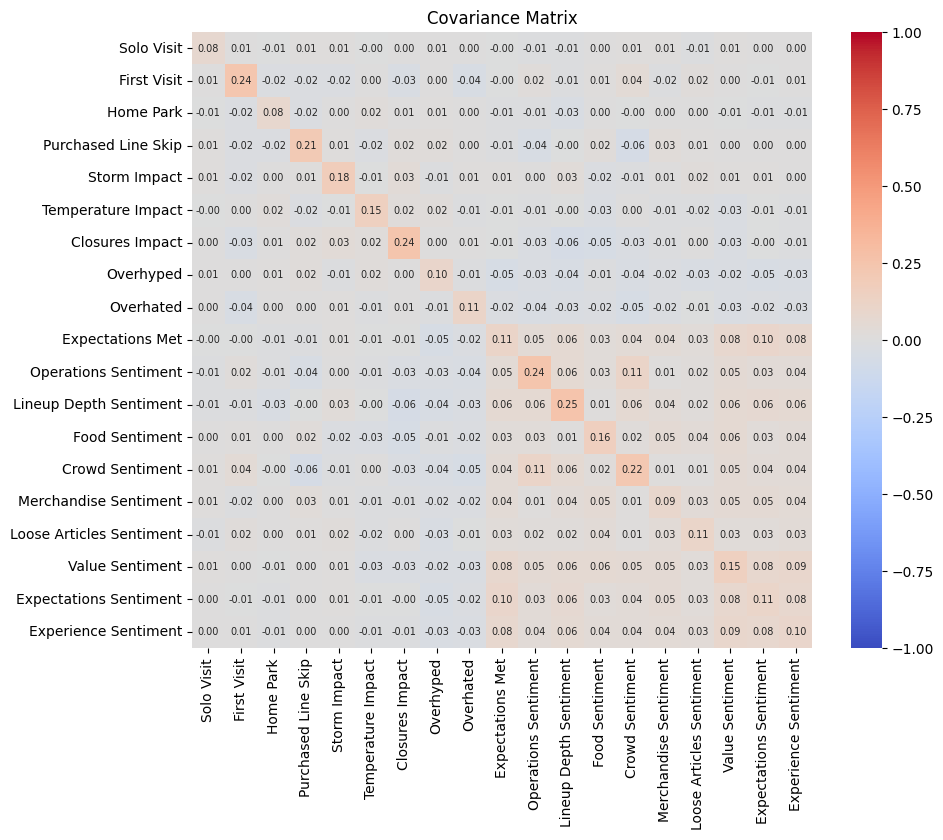

In [354]:
import calendar
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Combine all features into one DataFrame
numeric_features = filtered_df.select_dtypes(include=['number']).columns.tolist()
df_encoded = pd.concat([filtered_df[numeric_features]], axis=1)

# Calculate the covariance matrix
cov_matrix = df_encoded.cov()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(cov_matrix, dtype=bool), k=1)

# Find feature pairs with high or moderate correlation
print(f"Based on {df_encoded.shape[0]} rows of data")
abs_corr_matrix = np.abs(cov_matrix)
for label, threshold in [('high', 0.8), ('moderate', 0.3)]:
    corr_pairs = np.where((abs_corr_matrix > threshold) & (abs_corr_matrix < 1.0) & mask)
    corr_features = list(zip(cov_matrix.columns[corr_pairs[0]], cov_matrix.columns[corr_pairs[1]]))
    print(f"-----\n{label.title()} correlation pairs: {len(corr_features)}")
    for pair in corr_features:
        print(f"--> {pair[0]} & {pair[1]}")

# Visualize the covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={'size': 7})
plt.title('Covariance Matrix')
plt.show()

# Train The Model

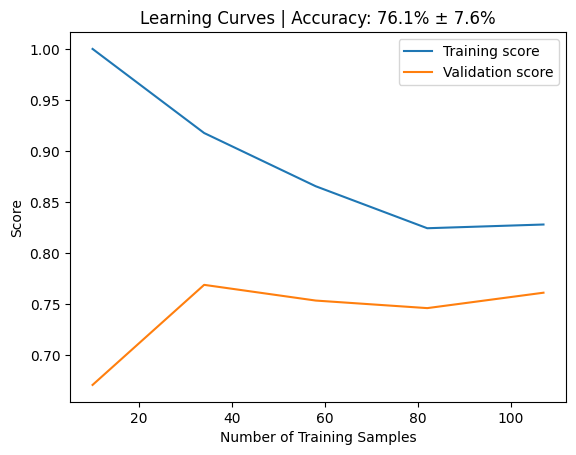

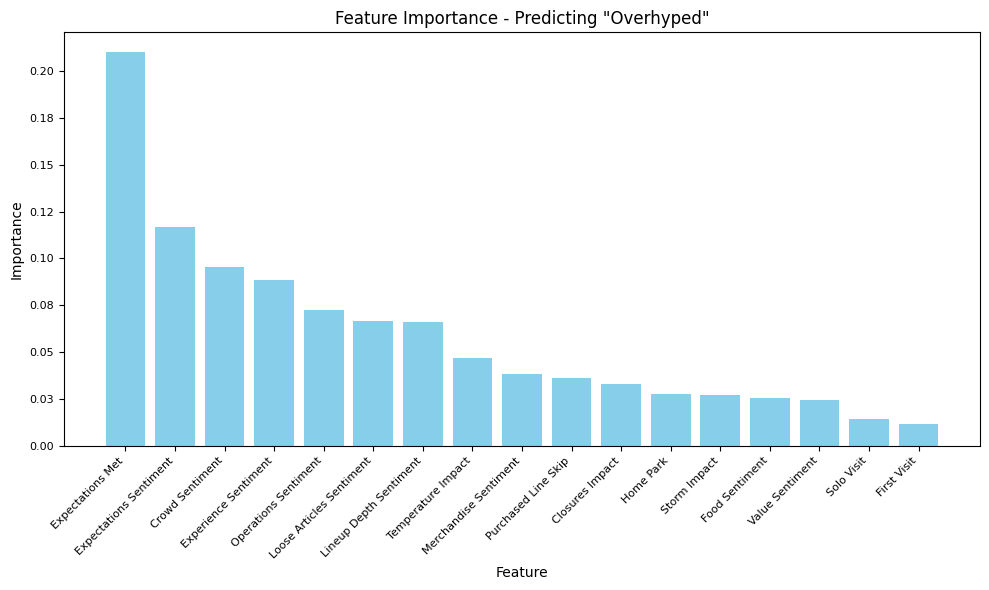

,Feature,Importance
7,Expectations Met,0.210323
15,Expectations Sentiment,0.116875
11,Crowd Sentiment,0.095560
16,Experience Sentiment,0.088576
8,Operations Sentiment,0.072260
13,Loose Articles Sentiment,0.066491
9,Lineup Depth Sentiment,0.066061
5,Temperature Impact,0.046753
12,Merchandise Sentiment,0.038218
3,Purchased Line Skip,0.036060


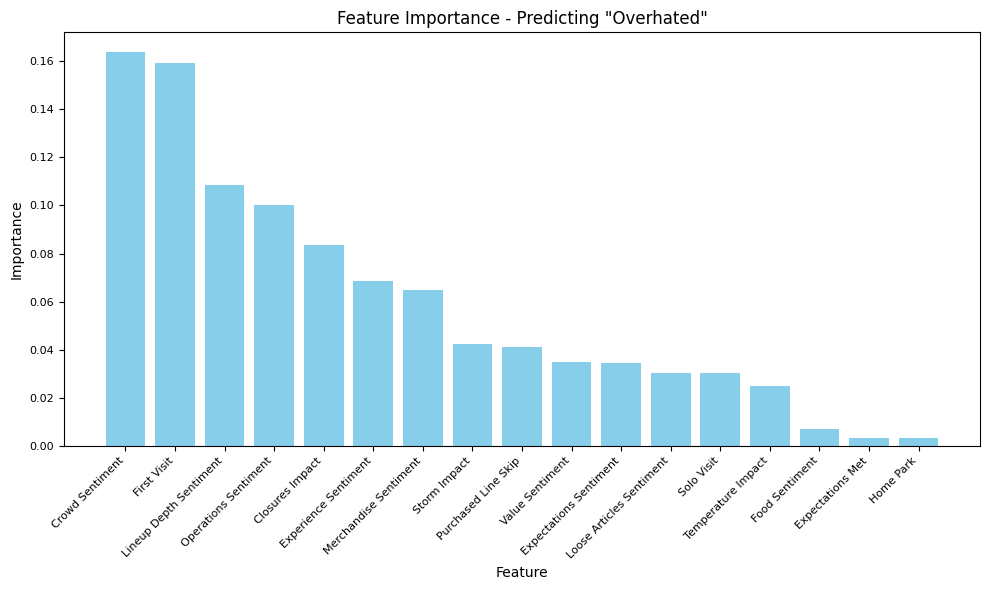

,Feature,Importance
11,Crowd Sentiment,0.163905
1,First Visit,0.159239
9,Lineup Depth Sentiment,0.108432
8,Operations Sentiment,0.100279
6,Closures Impact,0.083362
16,Experience Sentiment,0.068486
12,Merchandise Sentiment,0.064741
4,Storm Impact,0.042323
3,Purchased Line Skip,0.040981
14,Value Sentiment,0.034933


In [647]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Prepare the feature matrix and target matrix
targets = ['Overhyped', 'Overhated']
inputs = [col for col in df_encoded.columns if col not in targets]
X = df_encoded[inputs]
y = df_encoded[targets]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up classification model
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=20, max_depth=3, random_state=42), n_jobs=-1)

# Train the model
model.fit(X_train, y_train)

# Predict on the training and test sets
y_pred = model.predict(X_test)

# Compute cross-validated accuracy for each target
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
cv_mean_accuracy = cv_scores.mean()
cv_std_accuracy = cv_scores.std()

# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.title(f"Learning Curves | Accuracy: {cv_mean_accuracy*100:.1f}% ± {cv_std_accuracy*100:.1f}%")
plt.legend()
plt.show()
print('\n'+'='*140+'\n')

# Analyze feature importances
for i, target in enumerate(targets):
    # Extract feature importances for each target
    importances = model.estimators_[i].feature_importances_
    
    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': inputs,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.title(f"Feature Importance - Predicting \"{target}\"", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()
    display(importance_df)
    print('\n'+'='*140+'\n')